In [1]:
# [WIP] Custom script to create label.csv dynamically

# df = pd.DataFrame(columns = ['filename', 'class'])

# for folder in os.listdir():
#   # print(folder)
#   temp_df = pd.DataFrame()
#   temp_df['filename'] = os.listdir(folder)
#   temp_df['class'] = folder
#   print(11, temp_df.head())
#   # df = pd.concat([df, temp_df], axis=1, join='inner')
#   df.append(temp_df)
#   print(df.head())

## Importing Libraries

In [ ]:
from NN import Model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from skimage import io

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import pandas as pd
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

## Dataset creation

### 1. Custom Dataset

In [3]:
class customDataset(Dataset):
  
  def __init__(self, csv_file, root_dir, transform=None):
    self.labels = pd.read_csv(csv_file, header=None).sample(frac=1)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.labels.iloc[index, 0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.labels.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)

    return (image, y_label)


def get_split(csv_file, train_percentage=0.8):
  total = len(pd.read_csv(csv_file, header=None))
  train = int(total*train_percentage)
  test = total-train
  return train, test

In [4]:
TRAIN_DIR  = '/content/drive/MyDrive/ColabNotebooks/restart/cigarette_detector/inputs/data/train'
TEST_DIR   = '/content/drive/MyDrive/ColabNotebooks/restart/cigarette_detector/inputs/data/test'
IMG_SIZE   = 128
BATCH_SIZE = 32
classes    = ('non_smoking', 'smoking')

TRANSFORM  = transforms.Compose(
                [transforms.ToTensor(), #0-255 > 0-1, numpy to tensor
                transforms.Resize((IMG_SIZE, IMG_SIZE))
                ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] #
            )

In [5]:
trainloader = DataLoader(
                  torchvision.datasets.ImageFolder(TRAIN_DIR, transform=TRANSFORM),
                  batch_size=BATCH_SIZE, shuffle=True
                  )

testloader = DataLoader(
                  torchvision.datasets.ImageFolder(TEST_DIR, transform=TRANSFORM),
                  batch_size=BATCH_SIZE, shuffle=True
                  )

train_size = len(trainloader)*BATCH_SIZE
test_size  = len(testloader)*BATCH_SIZE

#### Checking sample

['non_smoking', 'non_smoking', 'non_smoking', 'smoking', 'non_smoking', 'non_smoking', 'smoking', 'smoking', 'smoking', 'non_smoking', 'non_smoking', 'smoking', 'non_smoking', 'smoking', 'non_smoking', 'smoking', 'smoking', 'non_smoking', 'smoking', 'non_smoking', 'non_smoking', 'non_smoking', 'smoking', 'non_smoking', 'non_smoking', 'non_smoking', 'non_smoking', 'non_smoking', 'smoking', 'non_smoking', 'smoking', 'smoking']


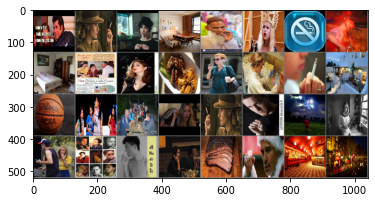

In [7]:
def imshow(img):
  img = img/2 + 0.5 #un-normalize
  npimg = img.numpy() # from tensor to np
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print([classes[i] for i in labels])

## Training

In [11]:
MODEL_NAME      = 'test2'
LEARNING_RATE   = 0.001
MOMENTUM        = 0.9
EPOCHS          = 10
WEIGHT_DECAY    = 0.0001
NUM_CLASSES     = len(classes)


model = Model(NUM_CLASSES).to(device)
# loss_function = nn.CrossEntropyLoss() # Setting up Loss Function

# # create optimizer
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, 
#                       #  momentum=MOMENTUM,
#                         weight_decay=WEIGHT_DECAY)

SAVED_MODEL_PATH = '/content/drive/MyDrive/ColabNotebooks/restart/cigarette_detector/saved_models/best_checkpoint_test2_epoch_5_testAcc0.78.model'
model.load_state_dict(torch.load(SAVED_MODEL_PATH))

best_accuracy = 0
total_epoch = 0

os.chdir('/content/drive/MyDrive/ColabNotebooks/restart/cigarette_detector/saved_models')

In [11]:
for epoch in range(EPOCHS):
  total_epoch += 1

  # Evaluation and training on training dataset
  model.train()
  
  train_accuracy = 0
  train_loss = 0

  for i, data in enumerate(trainloader):
    images, labels = data

    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    optimizer.zero_grad()

    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward() # Backpropogation
    optimizer.step()# Update the weight and bias using the computed gradients

    _, prediction = torch.max(outputs.data, 1)

    train_accuracy += int(torch.sum(prediction==labels.data))
    train_loss += loss.cpu().data*images.size(0)

  train_accuracy = train_accuracy/train_size
  train_loss     = train_loss/train_size

  # Evaluation on testing dataset
  model.eval()

  test_accuracy=0
  for i, (images, labels) in enumerate(testloader):
    if torch.cuda.is_available():
      images = Variable(images).to(device)
      labels = Variable(labels).to(device)

    output = model(images)
    _, prediction = torch.max(output.data, 1)
    test_accuracy += int(torch.sum(prediction==labels.data))
  
  test_accuracy = test_accuracy/test_size

  print(f'''
  Epoch       : {epoch+1}/{EPOCHS}
  Train Acc   : {train_accuracy}
  Train Loss  : {train_loss}
  Test Acc    : {test_accuracy}

  ''')

  if test_accuracy>best_accuracy:
    torch.save(model.state_dict(), f'best_checkpoint_{MODEL_NAME}_epoch_{total_epoch}_testAcc{round(test_accuracy, 2)}.model')
    best_accuracy = test_accuracy


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



  Epoch       : 1/10
  Train Acc   : 0.7069359756097561
  Train Loss  : 1.5514651536941528
  Test Acc    : 0.6859375

  

  Epoch       : 2/10
  Train Acc   : 0.8445121951219512
  Train Loss  : 0.37316277623176575
  Test Acc    : 0.721875

  

  Epoch       : 3/10
  Train Acc   : 0.9104420731707317
  Train Loss  : 0.23312336206436157
  Test Acc    : 0.6953125

  

  Epoch       : 4/10
  Train Acc   : 0.9165396341463414
  Train Loss  : 0.2240820825099945
  Test Acc    : 0.7328125

  

  Epoch       : 5/10
  Train Acc   : 0.9447408536585366
  Train Loss  : 0.146945983171463
  Test Acc    : 0.78125

  

  Epoch       : 6/10
  Train Acc   : 0.9649390243902439
  Train Loss  : 0.09524937719106674
  Test Acc    : 0.7109375

  

  Epoch       : 7/10
  Train Acc   : 0.9828506097560976
  Train Loss  : 0.05322066321969032
  Test Acc    : 0.7109375

  

  Epoch       : 8/10
  Train Acc   : 0.9889481707317073
  Train Loss  : 0.037991974502801895
  Test Acc    : 0.7

  

  Epoch       : 9/10
  Trai

In [13]:
test_accuracy = 0
for i, (images, labels) in enumerate(testloader):
  if torch.cuda.is_available():
    images = Variable(images).to(device)
    labels = Variable(labels).to(device)

  output = model(images)
  _, prediction = torch.max(output.data, 1)
  test_accuracy += int(torch.sum(prediction==labels.data))

test_accuracy = test_accuracy/test_size
test_accuracy

0.7796875

In [ ]:
output = net(imgs)
print('Actual :', [classes[i] for i in predicted])

Actual : ['truck', 'truck', 'truck', 'truck']


### Accuracy

In [ ]:
correct, total = 0, 0
with torch.no_grad():
  for data in tqdm(testloader):
    imgs, labels = data
    outputs = net(imgs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'''
Accuracy = {round((correct/total)*100, 2)}%''')

100%|██████████| 2500/2500 [00:08<00:00, 285.76it/s]


Accuracy = 61.28%
